In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false' 
import warnings
warnings.filterwarnings('ignore') 
from absl import logging
logging.set_verbosity(logging.ERROR)  


In [2]:

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from transformers import BertTokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import random
import re
import string
from nltk.translate.bleu_score import corpus_bleu


E0000 00:00:1733721952.178227  368307 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733721952.189470  368307 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [4]:

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'


In [5]:

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print(e)

Memory growth enabled for GPUs.


In [6]:
dataset, info = tfds.load('coco_captions', with_info=True, split='train[:5000]')

I0000 00:00:1733721956.489902  368307 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:

dataset_size = dataset.cardinality().numpy()
print(f"Dataset size: {dataset_size}")

Dataset size: 5000


In [8]:

base_model = InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)


print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [9]:

features_dir = "preprocessed_features"
os.makedirs(features_dir, exist_ok=True)



In [10]:
from PIL import Image
import numpy as np
import os
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tqdm import tqdm

def preprocess_image(example):
    img = example['image']
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
   
    return {'image': img, 'image/id': example['image/id'], 'original_image': img}



In [11]:
from tqdm import tqdm

def extract_features(dataset, features_dir):
    batch_size = 50 
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    for batch in tqdm(dataset, desc="Extracting features", unit="batch"):
        images = batch['image']
        image_ids = batch['image/id'].numpy()

        features_batch = model.predict(images, verbose=0)

        for idx, image_id in enumerate(image_ids):
            image_id_str = str(image_id)
            feature = features_batch[idx]
         
            feature_path = os.path.join(features_dir, f"{image_id_str}.npy")
            np.save(feature_path, feature)

extract_features(dataset, features_dir)


Extracting features:   0%|                                                                   | 0/100 [00:00<?, ?batch/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1733721961.620517  368434 service.cc:148] XLA service 0x7f7ea4002a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733721961.620589  368434 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1733721962.412723  368434 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1733721974.486377  368434 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting features: 100%|█████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.24batch/s]


In [12]:

import matplotlib.pyplot as plt

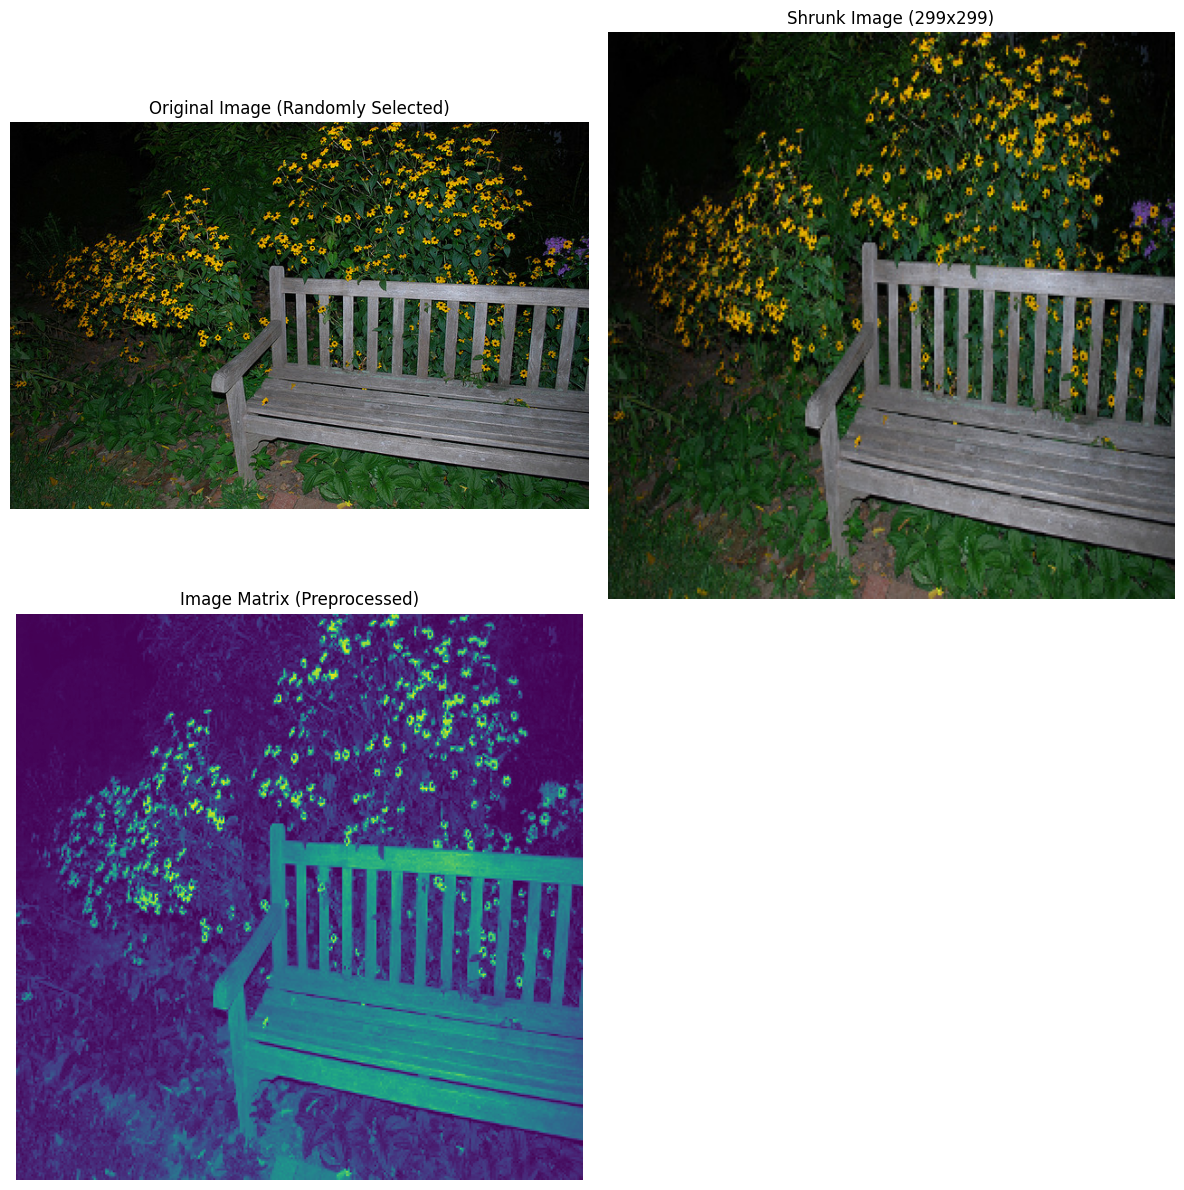

Randomly Selected Image ID: 480961
Extracted Features (Vector):
[0.05581897 0.48344898 0.4671716  ... 0.02619753 0.40294456 0.18119591]


In [13]:

def preprocess_image_test(example):
    img = example['image']
    img_resized = tf.image.resize(img, (299, 299))
    img_preprocessed = tf.keras.applications.inception_v3.preprocess_input(img_resized)
    return img, img_resized, img_preprocessed, example['image/id']

dataset_copy = dataset.shuffle(buffer_size=1000) 

base_model = InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)


for example in dataset_copy.take(1): 
    original_image, shrunk_image, preprocessed_image, image_id  = preprocess_image_test(example)


preprocessed_image_batch = np.expand_dims(preprocessed_image.numpy(), axis=0)

features = model.predict(preprocessed_image_batch, verbose=0)


plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(original_image.numpy().astype('uint8'))
plt.title("Original Image (Randomly Selected)")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(shrunk_image.numpy().astype('uint8'))
plt.title("Shrunk Image (299x299)")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(preprocessed_image.numpy()[..., 0], cmap='viridis')
plt.title("Image Matrix (Preprocessed)")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Randomly Selected Image ID: {image_id.numpy()}")
print("Extracted Features (Vector):")
print(features[0])


In [14]:

def extract_caption_for_image(dataset, selected_image_id):
    for example in tfds.as_numpy(dataset): 
        image_id = str(example['image/id'])
        if image_id == selected_image_id:  
            captions = [caption.decode('utf-8') for caption in example['captions']['text']]
            return captions
    return []


selected_image_id = str(image_id.numpy())

selected_image_captions = extract_caption_for_image(dataset, selected_image_id)


print(f"Captions for Image ID {selected_image_id}:")
for caption in selected_image_captions:
    print(f"- {caption}")


Captions for Image ID 480961:
- A bench in front of flowers at night
- A wood bench in front of yellow flowers.
- A photograph of flowers blooming next to a bench.
- a wooden bench sitting in a grass patch next to shrubbery and yellow and purple flowers.
- close up of a bench near a bush with flowers


In [15]:
import string
import re


def clean_captions_list(captions_list):
    table = str.maketrans('', '', string.punctuation)
    cleaned_captions = []
    for caption in captions_list:
      
        caption = caption.lower()
    
        caption = caption.translate(table)
   
        caption = re.sub(r'[^a-z\s]', '', caption)
       
        caption = re.sub(r'\s+', ' ', caption).strip()
      
        caption = 'startseq ' + caption + ' endseq'
        cleaned_captions.append(caption)
    return cleaned_captions


cleaned_selected_image_captions = clean_captions_list(selected_image_captions)


print(f"Cleaned Captions for Image ID {selected_image_id}:")
for caption in cleaned_selected_image_captions:
    print(f"- {caption}")


Cleaned Captions for Image ID 480961:
- startseq a bench in front of flowers at night endseq
- startseq a wood bench in front of yellow flowers endseq
- startseq a photograph of flowers blooming next to a bench endseq
- startseq a wooden bench sitting in a grass patch next to shrubbery and yellow and purple flowers endseq
- startseq close up of a bench near a bush with flowers endseq


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from pprint import pprint

captions_list_for_selected_image = cleaned_selected_image_captions

tokenizer_for_selected_image = Tokenizer()
tokenizer_for_selected_image.fit_on_texts(captions_list_for_selected_image)

vocab_size_for_selected_image = len(tokenizer_for_selected_image.word_index) + 1 

print('Vocabulary Size for Selected Image:', vocab_size_for_selected_image)
print('Word Index for Selected Image:')
pprint(tokenizer_for_selected_image.word_index)


Vocabulary Size for Selected Image: 29
Word Index for Selected Image:
{'a': 1,
 'and': 12,
 'at': 13,
 'bench': 3,
 'blooming': 17,
 'bush': 27,
 'close': 24,
 'endseq': 5,
 'flowers': 4,
 'front': 8,
 'grass': 20,
 'in': 7,
 'near': 26,
 'next': 10,
 'night': 14,
 'of': 6,
 'patch': 21,
 'photograph': 16,
 'purple': 23,
 'shrubbery': 22,
 'sitting': 19,
 'startseq': 2,
 'to': 11,
 'up': 25,
 'with': 28,
 'wood': 15,
 'wooden': 18,
 'yellow': 9}


In [17]:
def extract_captions(dataset):
    captions_dict = {}
    for example in tqdm(tfds.as_numpy(dataset), desc="Extracting captions"):
        image_id = str(example['image/id'])
       
        captions = [caption.decode('utf-8') for caption in example['captions']['text']]
        captions_dict[image_id] = captions
    return captions_dict

captions = extract_captions(dataset)


Extracting captions: 100%|████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3273.08it/s]


In [18]:
import re
import string

def clean_captions(captions_dict):
    table = str.maketrans('', '', string.punctuation)
    for key, captions_list in captions_dict.items():
        cleaned_captions = []
        for caption in captions_list:
           
            caption = caption.lower()
           
            caption = caption.translate(table)
           
            caption = re.sub(r'[^a-z\s]', '', caption)
            
            caption = re.sub(r'\s+', ' ', caption).strip()
           
            caption = 'startseq ' + caption + ' endseq'
            cleaned_captions.append(caption)
        captions_dict[key] = cleaned_captions
    return captions_dict


captions = clean_captions(captions)


## Tokenize Captions

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

all_captions = []
for captions_list in captions.values():
    all_captions.extend(captions_list)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1 
print('Vocabulary Size:', vocab_size)


Vocabulary Size: 7206


In [20]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Tokenizer saved to tokenizer.pkl")

Tokenizer saved to tokenizer.pkl


##  Determine Maximum Caption Length

In [21]:
max_length = max(len(caption.split()) for caption in all_captions)
print('Maximum Caption Length:', max_length)


Maximum Caption Length: 47


## Split Data into Training and Validation Sets

In [22]:
from sklearn.model_selection import train_test_split

image_ids = list(captions.keys())

train_ids, val_ids = train_test_split(image_ids, test_size=0.1, random_state=42)

train_captions = {img_id: captions[img_id] for img_id in train_ids}
val_captions = {img_id: captions[img_id] for img_id in val_ids}


## Defining data generator

In [23]:
def data_generator(captions, features_dir, tokenizer, max_length, vocab_size, batch_size):
    image_ids = list(captions.keys())
    while True:
        random.shuffle(image_ids)
        X1, X2, y = [], [], []
        for image_id in image_ids:
           
            feature_path = os.path.join(features_dir, f"{image_id}.npy")
            photo_feature = np.load(feature_path).astype('float32')
            photo_feature = np.squeeze(photo_feature) 
            
            captions_list = captions[image_id]
            for caption in captions_list:
                
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                   
                    in_seq, out_seq = seq[:i], seq[i]
                   
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                   
                    X1.append(photo_feature)
                    X2.append(in_seq)
                    y.append(out_seq)
                    if len(X1) == batch_size:
                       
                        y_cat = to_categorical(y, num_classes=vocab_size).astype('float32')
                        yield ((np.stack(X1), np.array(X2)), y_cat)
                        X1, X2, y = [], [], []
        if len(X1) > 0:
            y_cat = to_categorical(y, num_classes=vocab_size).astype('float32')
            yield ((np.stack(X1), np.array(X2)), y_cat)
            X1, X2, y = [], [], []


In [24]:
# # Get a batch from the training generator
# train_gen = data_generator(train_captions, features_dir, tokenizer, max_length, vocab_size, batch_size=64)
# X_train, y_train = next(train_gen)
# print(f"X_train[0] dtype: {X_train[0].dtype}, X_train[1] dtype: {X_train[1].dtype}, y_train dtype: {y_train.dtype}")
# print(f"X_train[0] shape: {X_train[0].shape}, X_train[1] shape: {X_train[1].shape}, y_train shape: {y_train.shape}")


In [25]:
# print(f"X_train[0] dtype: {X_train[0].dtype}, X_train[1] dtype: {X_train[1].dtype}, y_train dtype: {y_train.dtype}")


In [26]:

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)


decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 47, 256)   │  1,844,736 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 47, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 47)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7206)      │  1,851,942 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,812,326 (18.36 MB)

 Trainable params: 4,812,326 (18.36 MB)

 Non-trainable params: 0 (0.00 B)

## Train model

In [27]:

def calc_steps(captions_dict, batch_size):
    total_captions = sum(len(captions_list) for captions_list in captions_dict.values())
    total_sequences = sum(len(caption.split()) - 1 for captions_list in captions_dict.values() for caption in captions_list)
    steps = total_sequences // batch_size
    return steps

batch_size = 64  
vocab_size = len(tokenizer.word_index) + 1


def calc_total_sequences(captions_dict):
    total = 0
    for captions_list in captions_dict.values():
        for caption in captions_list:
            total += len(caption.split()) - 1
    return total
    

train_sequences = calc_total_sequences(train_captions)
val_sequences = calc_total_sequences(val_captions)
train_steps = train_sequences // batch_size
val_steps = val_sequences // batch_size
print(f'Train steps per epoch: {train_steps}, Validation steps per epoch: {val_steps}')



Train steps per epoch: 4038, Validation steps per epoch: 448


In [28]:

train_generator = data_generator(train_captions, features_dir, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(val_captions, features_dir, tokenizer, max_length, vocab_size, batch_size)


In [29]:

checkpoint = ModelCheckpoint('best_model.keras', monitor='loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='loss', patience=3)


In [30]:


output_signature = (
    (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
     tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_captions, features_dir, tokenizer, max_length, vocab_size, batch_size),
    output_signature=output_signature
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_captions, features_dir, tokenizer, max_length, vocab_size, batch_size),
    output_signature=output_signature
)

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


Epoch 1/20
4037/4038 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7454
Epoch 1: loss improved from inf to 4.21417, saving model to best_model.keras
4038/4038 ━━━━━━━━━━━━━━━━━━━━ 67s 16ms/step - loss: 4.7452 - val_loss: 3.6923
Epoch 2/20
4037/4038 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.4096
Epoch 2: loss improved from 4.21417 to 3.36410, saving model to best_model.keras
4038/4038 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - loss: 3.4096 - val_loss: 3.5011
Epoch 3/20
4038/4038 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0434
Epoch 3: loss improved from 3.36410 to 3.04764, saving model to best_model.keras
4038/4038 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step - loss: 3.0434 - val_loss: 3.4494
Epoch 4/20
4036/4038 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8399
Epoch 4: loss improved from 3.04764 to 2.85526, saving model to best_model.keras
4038/4038 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step - loss: 2.8399 - val_loss: 3.4886
Epoch 5/20
4037/4038 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7080
Epoch 5: loss 

In [32]:
print(history.history.keys())


dict_keys(['loss', 'val_loss'])


## Plots over epochs

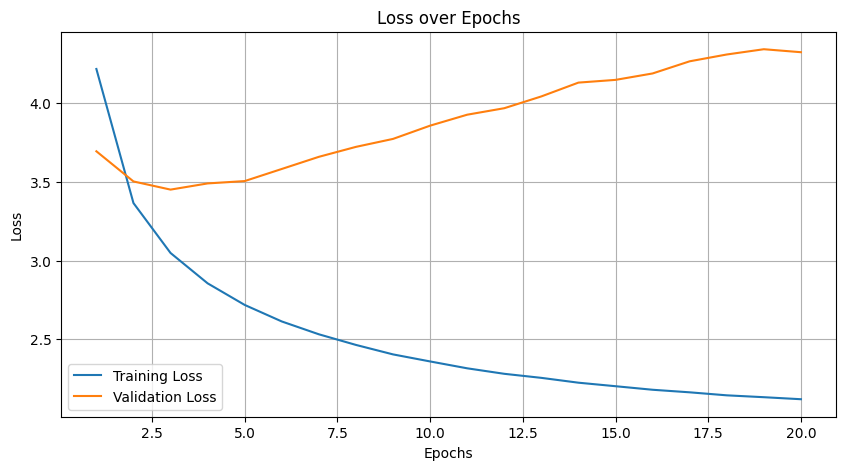

In [34]:
import matplotlib.pyplot as plt

train_loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [35]:
import pickle

with open('model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


## Generate captions

In [37]:
def generate_caption(model, tokenizer, photo_feature, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        yhat = model.predict([photo_feature.reshape(1, 2048), sequence], verbose=0)

        yhat = np.argmax(yhat)

        word = tokenizer.index_word.get(yhat)
        if word is None:
            break

        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

## BLEU Score Evaluation

In [38]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm 

def evaluate_model(model, captions_dict, features_dir, tokenizer, max_length):
    actual, predicted = [], []

    for image_id, captions_list in tqdm(captions_dict.items(), desc="Evaluating", total=len(captions_dict)):
 
        feature_path = os.path.join(features_dir, f"{image_id}.npy")
        photo_feature = np.load(feature_path).astype('float32')
        photo_feature = np.squeeze(photo_feature)  
      
        y_pred = generate_caption(model, tokenizer, photo_feature, max_length)
        y_pred = y_pred.split()[1:-1]  
        references = [c.split()[1:-1] for c in captions_list]
        actual.append(references)
        predicted.append(y_pred)

    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\nEvaluation Metrics:')
    print('BLEU-1: %f' % bleu1)
    print('BLEU-2: %f' % bleu2)
    print('BLEU-3: %f' % bleu3)
    print('BLEU-4: %f' % bleu4)


evaluate_model(model, val_captions, features_dir, tokenizer, max_length)


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [07:15<00:00,  1.15it/s]



Evaluation Metrics:
BLEU-1: 0.588150
BLEU-2: 0.389478
BLEU-3: 0.248024
BLEU-4: 0.154617


In [39]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model

base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')


In [40]:
def generate_caption_test_image(image_path):

    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = preprocess_input(image)
  
    photo_feature = base_model.predict(image.reshape((1, 299, 299, 3)), verbose=0)
    photo_feature = np.squeeze(photo_feature) 
 
    caption = generate_caption(model, tokenizer, photo_feature, max_length)
    print('Generated Caption:', caption)


Generated Caption: startseq a man in a suit and tie endseq


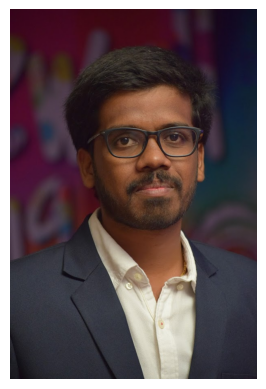

In [41]:
import matplotlib.pyplot as plt

def display_image_with_caption(image_path):

    generate_caption_test_image(image_path)
   
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


display_image_with_caption('venkat_.JPG')


## generate image caption and save to output dir


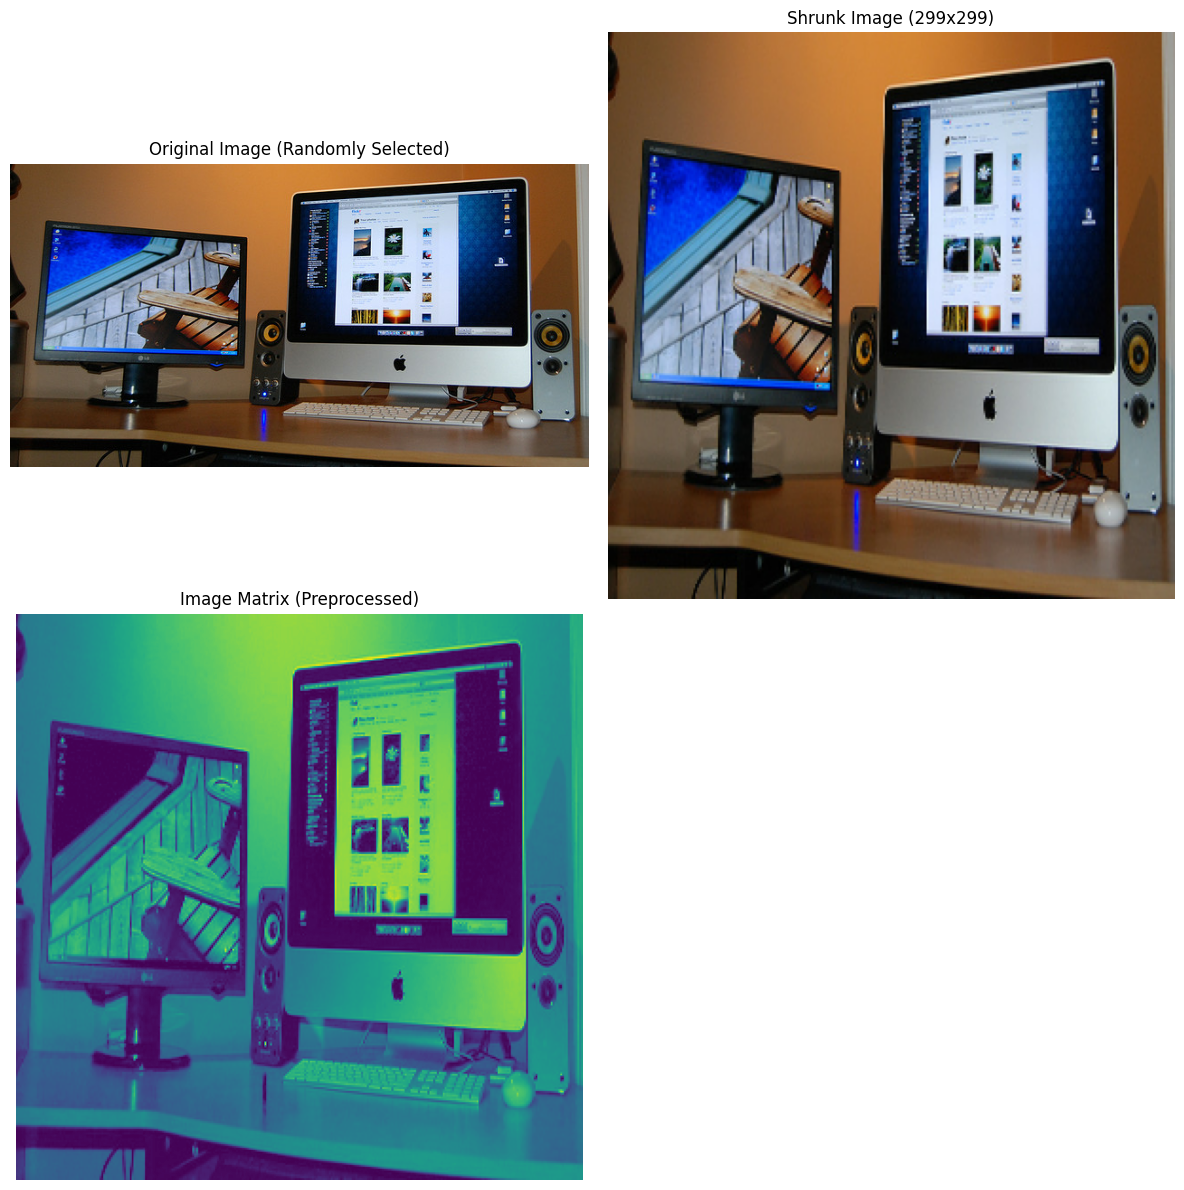

Randomly Selected Image ID: 514156
Extracted Features (Vector):
[0.05740226 0.1925492  0.9298929  ... 0.22451201 0.1278746  0.03573599]
Generated Caption for Randomly Selected Image ID 514156: a laptop computer sitting on top of a desk
Original Captions:
Caption 1: A couple of desktop computer monitors sitting on top of a desk.
Caption 2: A computer set up on a desk with two monitors.
Caption 3: This is a picture of a desk top with two computers on top of it
Caption 4: Two computers are seen set up on a desk.
Caption 5: The two monitors are sitting side by side.

BLEU Scores:
BLEU-1: 0.8889
BLEU-2: 0.7454
BLEU-3: 0.6848
BLEU-4: 0.5704


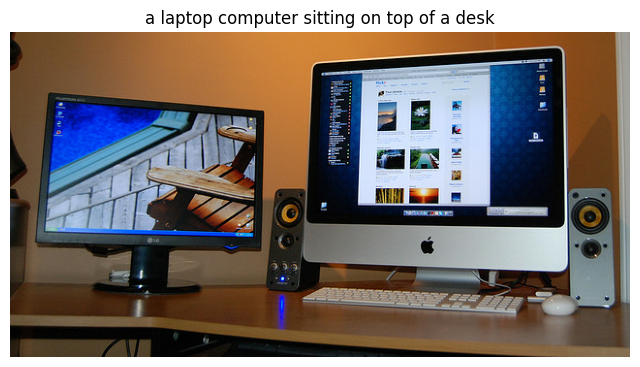

Image with caption saved to: output_images/514156.png


In [50]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.applications.inception_v3 import preprocess_input
import pickle
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu


caption_model = load_model('best_model.keras')  
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)


base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')


max_length = 47  
output_dir = "output_images" 
os.makedirs(output_dir, exist_ok=True) 


def preprocess_image(example):
    img = example['image']
    img_resized = tf.image.resize(img, (299, 299))
    img_preprocessed = preprocess_input(img_resized)
    return img, img_resized, img_preprocessed, example['image/id'], example['captions']['text']


def generate_caption_from_features(photo_feature):
    """
    Generate a caption given pre-extracted features.
    
    Parameters:
        photo_feature (numpy.ndarray): Pre-extracted feature vector.
    
    Returns:
        str: Generated caption.
    """
    in_text = 'startseq'
    for _ in range(max_length):
       
        sequence = tokenizer.texts_to_sequences([in_text])[0]
      
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
     
        yhat = caption_model.predict([photo_feature.reshape(1, 2048), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return ' '.join(in_text.split()[1:-1])


dataset, info = tfds.load('coco_captions', with_info=True, split='train')
dataset_copy = dataset.shuffle(buffer_size=1000) 


for example in dataset_copy.take(1):  
    original_image, shrunk_image, preprocessed_image, image_id, original_captions = preprocess_image(example)


preprocessed_image_batch = np.expand_dims(preprocessed_image.numpy(), axis=0)


features = base_model.predict(preprocessed_image_batch, verbose=0)


plt.figure(figsize=(12, 12))


plt.subplot(2, 2, 1)
plt.imshow(original_image.numpy().astype('uint8'))
plt.title("Original Image (Randomly Selected)")
plt.axis('off')


plt.subplot(2, 2, 2)
plt.imshow(shrunk_image.numpy().astype('uint8'))
plt.title("Shrunk Image (299x299)")
plt.axis('off')


plt.subplot(2, 2, 3)
plt.imshow(preprocessed_image.numpy()[..., 0], cmap='viridis')
plt.title("Image Matrix (Preprocessed)")
plt.axis('off')

plt.tight_layout()
plt.show()


print(f"Randomly Selected Image ID: {image_id.numpy()}")
print("Extracted Features (Vector):")
print(features[0])


predicted_caption = generate_caption_from_features(features)
print(f"Generated Caption for Randomly Selected Image ID {image_id.numpy()}: {predicted_caption}")


decoded_captions = [cap.decode('utf-8') for cap in original_captions.numpy()]
print("Original Captions:")
for idx, cap in enumerate(decoded_captions, start=1):
    print(f"Caption {idx}: {cap}")


reference_captions = [cap.split() for cap in decoded_captions]  
predicted_tokens = predicted_caption.split() 

# BLEU scores
bleu1 = sentence_bleu(reference_captions, predicted_tokens, weights=(1.0, 0, 0, 0))  # BLEU-1
bleu2 = sentence_bleu(reference_captions, predicted_tokens, weights=(0.5, 0.5, 0, 0))  # BLEU-2
bleu3 = sentence_bleu(reference_captions, predicted_tokens, weights=(0.33, 0.33, 0.33, 0))  # BLEU-3
bleu4 = sentence_bleu(reference_captions, predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25))  # BLEU-4

print("\nBLEU Scores:")
print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")


def display_and_save_image_with_caption(image, caption, image_id, output_dir):
    """
    Display and save the image with its caption.
    
    Parameters:
        image (numpy.ndarray): Original image array.
        caption (str): Generated caption.
        image_id (str): Image ID used for saving.
        output_dir (str): Directory to save the image.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(image.astype('uint8'))
    plt.axis('off')
    plt.title(caption)
    
    # Save the image with caption
    output_path = os.path.join(output_dir, f"{image_id}.png")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f"Image with caption saved to: {output_path}")

display_and_save_image_with_caption(original_image.numpy(), predicted_caption, image_id.numpy(), output_dir)


## Image along with captions and BLEU Score

Generated Caption for Randomly Selected Image ID 514156: a laptop computer sitting on top of a desk
Original Captions:
Caption 1: A couple of desktop computer monitors sitting on top of a desk.
Caption 2: A computer set up on a desk with two monitors.
Caption 3: This is a picture of a desk top with two computers on top of it
Caption 4: Two computers are seen set up on a desk.
Caption 5: The two monitors are sitting side by side.

BLEU Scores:
BLEU-1: 0.8889
BLEU-2: 0.7454
BLEU-3: 0.6848
BLEU-4: 0.5704


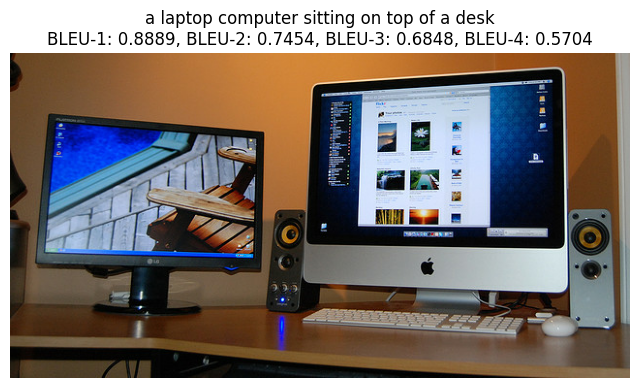

Image with caption and BLEU scores saved to: output_images/514156.png


In [60]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.applications.inception_v3 import preprocess_input
import pickle
from nltk.translate.bleu_score import sentence_bleu

caption_model = load_model('best_model.keras')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)


base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')


max_length = 47 
output_dir = "output_images" 
os.makedirs(output_dir, exist_ok=True)  


def preprocess_image(example):
    img = example['image']
    img_resized = tf.image.resize(img, (299, 299))
    img_preprocessed = preprocess_input(img_resized)
    return img, img_resized, img_preprocessed, example['image/id'], example['captions']['text']


def generate_caption_from_features(photo_feature):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = caption_model.predict([photo_feature.reshape(1, 2048), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return ' '.join(in_text.split()[1:-1])  


dataset, info = tfds.load('coco_captions', with_info=True, split='train')
dataset_copy = dataset.shuffle(buffer_size=1000)  


for example in dataset_copy.take(1): 
    original_image, shrunk_image, preprocessed_image, image_id, original_captions = preprocess_image(example)


preprocessed_image_batch = np.expand_dims(preprocessed_image.numpy(), axis=0)


features = base_model.predict(preprocessed_image_batch, verbose=0)


predicted_caption = generate_caption_from_features(features)
print(f"Generated Caption for Randomly Selected Image ID {image_id.numpy()}: {predicted_caption}")


decoded_captions = [cap.decode('utf-8') for cap in original_captions.numpy()]
print("Original Captions:")
for idx, cap in enumerate(decoded_captions, start=1):
    print(f"Caption {idx}: {cap}")


reference_captions = [cap.split() for cap in decoded_captions]  
predicted_tokens = predicted_caption.split()  

# BLEU scores
bleu1 = sentence_bleu(reference_captions, predicted_tokens, weights=(1.0, 0, 0, 0))  # BLEU-1
bleu2 = sentence_bleu(reference_captions, predicted_tokens, weights=(0.5, 0.5, 0, 0))  # BLEU-2
bleu3 = sentence_bleu(reference_captions, predicted_tokens, weights=(0.33, 0.33, 0.33, 0))  # BLEU-3
bleu4 = sentence_bleu(reference_captions, predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25))  # BLEU-4

print("\nBLEU Scores:")
print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")


def display_and_save_image_with_caption(image, caption, image_id, bleu_scores, output_dir):
    """
    Display and save the image with its caption and BLEU scores.
    
    Parameters:
        image (numpy.ndarray): Original image array.
        caption (str): Generated caption.
        image_id (str): Image ID used for saving.
        bleu_scores (dict): BLEU scores to overlay on the image.
        output_dir (str): Directory to save the image.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(image.astype('uint8'))
    plt.axis('off')
    overlay_text = f"{caption}\nBLEU-1: {bleu_scores['bleu1']:.4f}, BLEU-2: {bleu_scores['bleu2']:.4f}, BLEU-3: {bleu_scores['bleu3']:.4f}, BLEU-4: {bleu_scores['bleu4']:.4f}"
    plt.title(overlay_text)
    
    
    output_path = os.path.join(output_dir, f"{image_id}.png")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f"Image with caption and BLEU scores saved to: {output_path}")

bleu_scores = {'bleu1': bleu1, 'bleu2': bleu2, 'bleu3': bleu3, 'bleu4': bleu4}
display_and_save_image_with_caption(original_image.numpy(), predicted_caption, image_id.numpy(), bleu_scores, output_dir)


In [52]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import preprocess_input
import pickle
from nltk.translate.bleu_score import sentence_bleu


caption_model = load_model('best_model.keras')  
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)


base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')


max_length = 47  
output_dir = "output_frames_with_bleu" 
os.makedirs(output_dir, exist_ok=True)  


def generate_caption_from_features(photo_feature):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = caption_model.predict([photo_feature.reshape(1, 2048), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return ' '.join(in_text.split()[1:-1])


def extract_frames(video_path, frame_rate=1):
    video = cv2.VideoCapture(video_path)
    fps = int(video.get(cv2.CAP_PROP_FPS))
    interval = fps // frame_rate
    frames = []
    success, frame = video.read()
    count = 0
    while success:
        if count % interval == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) 
        success, frame = video.read()
        count += 1
    video.release()
    return frames


def extract_features_from_frame(frame):
    frame_resized = cv2.resize(frame, (299, 299))  # Resize to 299x299
    frame_preprocessed = preprocess_input(np.expand_dims(frame_resized, axis=0))
    features = base_model.predict(frame_preprocessed, verbose=0)
    return np.squeeze(features)


def compute_bleu_score(predicted_caption, reference_captions):
    reference_tokens = [cap.split() for cap in reference_captions]
    predicted_tokens = predicted_caption.split()
    bleu1 = sentence_bleu(reference_tokens, predicted_tokens, weights=(1.0, 0, 0, 0))  # BLEU-1
    bleu2 = sentence_bleu(reference_tokens, predicted_tokens, weights=(0.5, 0.5, 0, 0))  # BLEU-2
    bleu3 = sentence_bleu(reference_tokens, predicted_tokens, weights=(0.33, 0.33, 0.33, 0))  # BLEU-3
    bleu4 = sentence_bleu(reference_tokens, predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25))  # BLEU-4
    return bleu1, bleu2, bleu3, bleu4


def save_frame_with_caption_and_bleu(frame, caption, bleu_scores, frame_index, output_dir):
    plt.figure(figsize=(8, 8))
    plt.imshow(frame)
    plt.axis('off')
    overlay_text = f"{caption}\nBLEU-1: {bleu_scores[0]:.4f}, BLEU-2: {bleu_scores[1]:.4f}, BLEU-3: {bleu_scores[2]:.4f}, BLEU-4: {bleu_scores[3]:.4f}"
    plt.title(overlay_text)
    output_path = os.path.join(output_dir, f"frame_{frame_index:04d}.png")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"Frame {frame_index} saved with caption and BLEU scores: {caption}")


def process_video(video_path, reference_captions, frame_rate=1):
    """
    Process the video to extract frames, generate captions, evaluate BLEU scores, and save the frames with captions.
    
    Parameters:
        video_path (str): Path to the input video.
        reference_captions (list of list of str): List of reference captions for BLEU evaluation.
        frame_rate (int): Number of frames to process per second.
    """
    print("Extracting frames from video...")
    frames = extract_frames(video_path, frame_rate)
    print(f"Extracted {len(frames)} frames from the video.")

    for idx, frame in enumerate(frames):
        # Extract features
        features = extract_features_from_frame(frame)
        # Generate caption
        predicted_caption = generate_caption_from_features(features)
        # Compute BLEU scores
        bleu_scores = compute_bleu_score(predicted_caption, reference_captions)
        # Save frame with caption and BLEU scores
        save_frame_with_caption_and_bleu(frame, predicted_caption, bleu_scores, idx, output_dir)


video_path = 'test-clip.mp4' 
reference_captions = [
    "a table containing laptop, monitor",
    "A chair",
    "Table with mouse and mobile",
    "A desk with a laptop, mouse, and monitor"
]  
process_video(video_path, reference_captions, frame_rate=1)  


Extracting frames from video...
Extracted 6 frames from the video.
Frame 0 saved with caption and BLEU scores: a laptop computer sitting on top of a desk
Frame 1 saved with caption and BLEU scores: a desk with a laptop computer and a keyboard
Frame 2 saved with caption and BLEU scores: a desk with a laptop computer and a keyboard
Frame 3 saved with caption and BLEU scores: a laptop computer sitting on top of a desk
Frame 4 saved with caption and BLEU scores: a dog is laying on a bed with a dog
Frame 5 saved with caption and BLEU scores: a cat sitting on a bed with a dog on the floor


In [1]:
from tensorflow.keras.models import load_model


caption_model = load_model('best_model.keras')  

2024-12-09 20:15:24.074291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 20:15:24.086290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733800524.100019    9939 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733800524.104879    9939 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 20:15:24.130888: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

caption_model = load_model('best_model.keras')



In [17]:

caption_model.layers[0].name = "Image_Input_(299x299x3)"
caption_model.layers[1].name = "Text_Input_(seq)"
caption_model.layers[2].name = "Embedding_Text_Branch"
caption_model.layers[3].name = "Dropout_Text_Branch"
caption_model.layers[4].name = "Dropout_Image_Branch"
caption_model.layers[5].name = "Dense_Image_Branch_(256_ReLU)"
caption_model.layers[6].name = "LSTM_Text_Branch_(256)"
caption_model.layers[7].name = "Add_Merge_(Image+Text)"
caption_model.layers[8].name = "Dense_Combined_(256_ReLU)"
caption_model.layers[9].name = "Dense_Output_(vocab_size)"


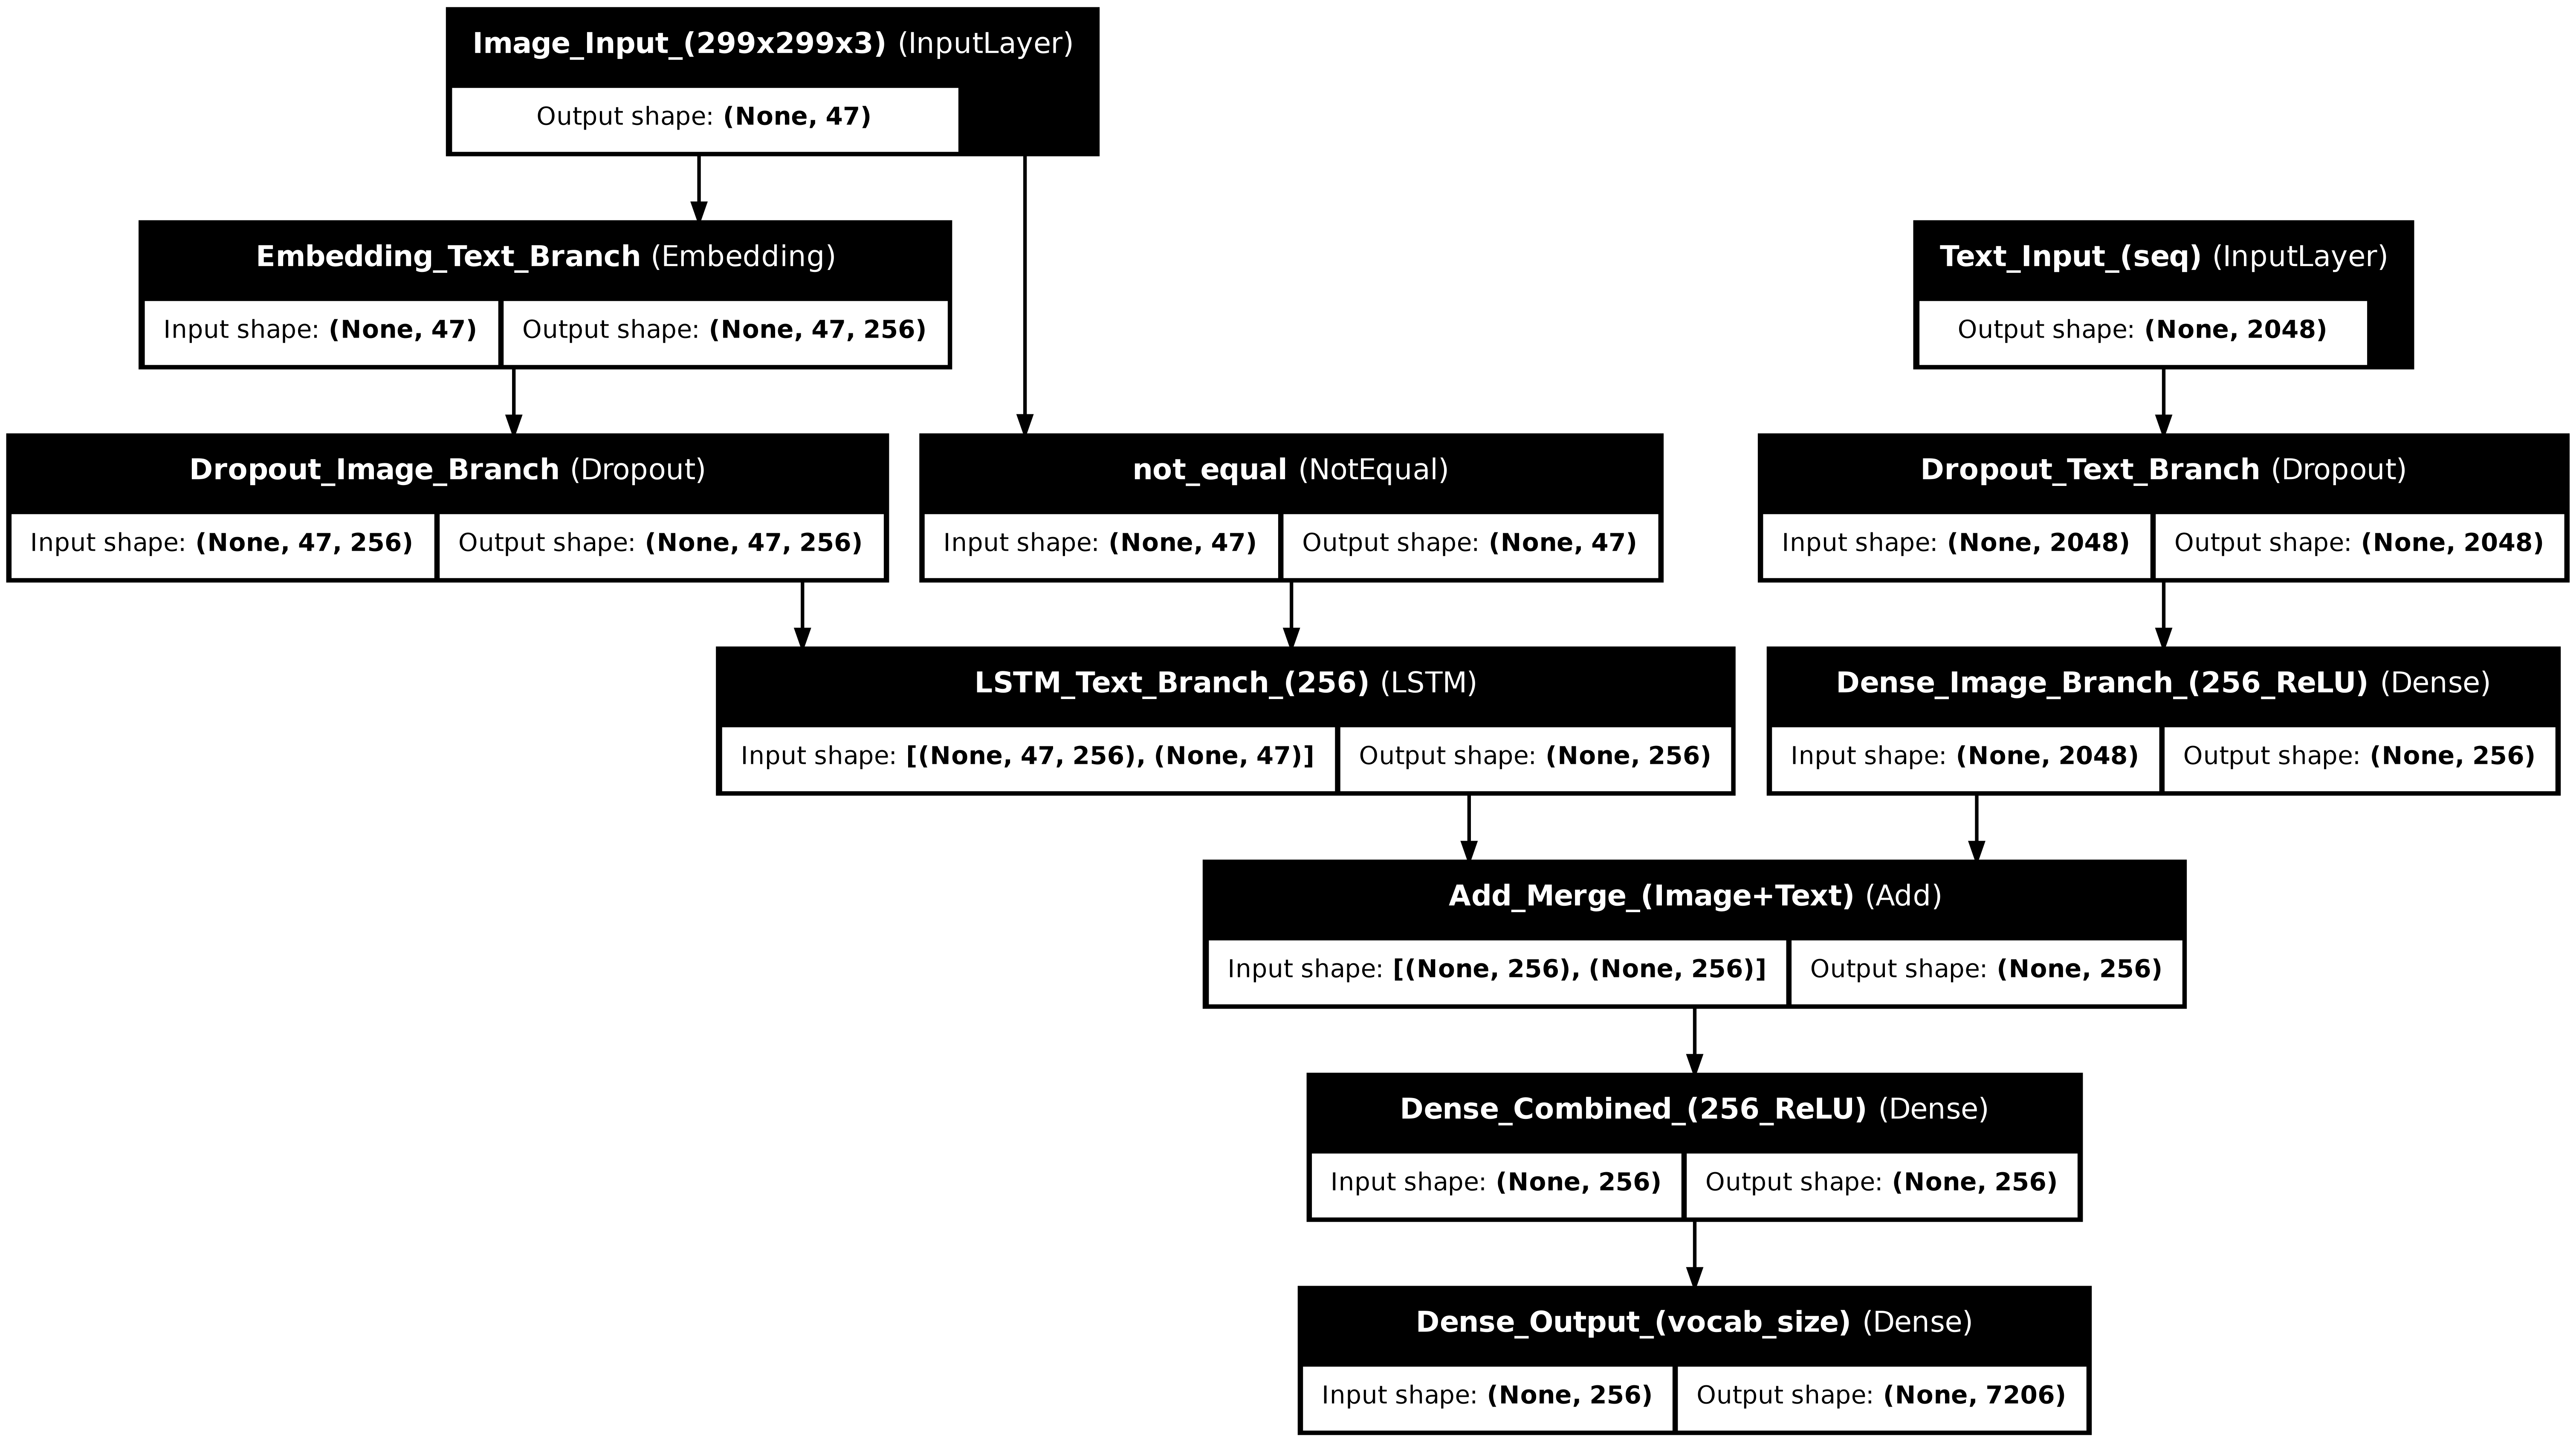

In [19]:

plot_model(caption_model,
           to_file='custom_named_model_plot.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB',
           dpi=300)